## Visualización de la aproximación de una función usando una red neuronal
Este notebook dispone de dos parámetros:
- init_weihgts: si (true) establece los pesos de la red a unos valores precalculados.
- train_network: si (true) entrena la red, en caso contrario usa los pesos preestablecidos.

In [1]:
init_weights=True
train_network=False

Importamos los archivos necesarios y establecemos la semilla para obtener siempre los mismos resultados.

In [2]:
import torch
import torch.nn as nn

torch.manual_seed(0)

### Definición del modelo
Vamos a definir un modelo siemple: una red neuronal con:
- Una capa de entrada de una neurona
- Una capa oculta de dos neuronas
- Una capa de salida con una neurona
- Función de activación softplus

In [3]:
def softplus(x):
    return torch.log(torch.exp(x) + 1)

class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.l1 = nn.Linear(1,2)
        self.l2 = nn.Linear(2,1)
        if init_weights:
          self.l1.weight = nn.Parameter(torch.Tensor([[-13.8038],[-5.7232]]))
          self.l1.bias = nn.Parameter(torch.Tensor([6.3613, 2.1516]))
          self.l2.weight = nn.Parameter(torch.Tensor([[-1.9106, 5.4986]]))
          self.l2.bias = nn.Parameter(torch.Tensor([-0.2564]))

    def forward(self, x):
        x = self.l1(x)
        x = softplus(x)
        x = self.l2(x)
        return x

model = Modelo()
print(model)
print(model.state_dict())

Modelo(
  (l1): Linear(in_features=1, out_features=2, bias=True)
  (l2): Linear(in_features=2, out_features=1, bias=True)
)
OrderedDict([('l1.weight', tensor([[-13.8038],
        [ -5.7232]])), ('l1.bias', tensor([6.3613, 2.1516])), ('l2.weight', tensor([[-1.9106,  5.4986]])), ('l2.bias', tensor([-0.2564]))])


### Definición del dataset
En este caso nuestros datos son muy simples. En la 'X' tenemos la dosis de un medicamento y en la 'y' si este es efectivo o no.

In [10]:
x = torch.Tensor([0.01,0.1,0.2,0.4,0.45,0.5,0.6,0.8,0.9,1])
y = torch.Tensor([0,0,0,1,1,1,1,0,0,0])

data = torch.utils.data.TensorDataset(x,y)
data_loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=True)

Si dibujamos estos datos podemos ver como este problema no sería resoluble por un modelo lineal:

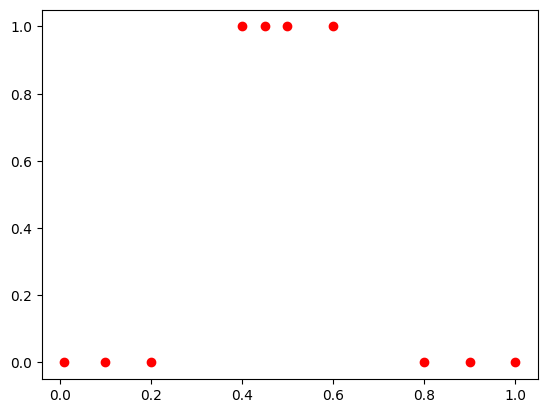

In [13]:
import matplotlib.pyplot as plt

plt.scatter(x.numpy(), y.numpy(),color='red')
plt.show()

### Entrenando la red
Vamos a crear un bucle de entrenamiento básico en PyTorch para aprender los pesos optimos para nuestra red usando descenso de gradiente

In [14]:
if train_network:
  
  loss=nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  
  for epoch in range(5000):
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(data_loader):
      optimizer.zero_grad()
      output = model(data)
      loss_value = loss(output, target)
      loss_value.backward()
      optimizer.step()
      epoch_loss += loss_value.item()
    if epoch%1000 == 0:
      print(f'Epoch: {epoch} Loss: {epoch_loss/len(data_loader)}')

### Mostrando los resultados
Vamos a mostrar que nuestro modelo se ajusta bastante bien a los datos originales

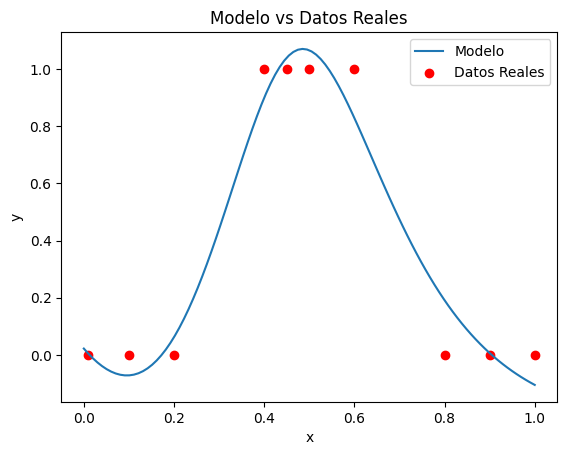

In [15]:
# Generamos datos para la gráfica
x_graph = torch.linspace(0, 1, 100).unsqueeze(1)
with torch.no_grad():
  y_graph = model(x_graph)

# Convertimos a numpy para graficar
x_graph = x_graph.numpy()
y_graph = y_graph.numpy()
x = x.numpy()
y = y.numpy()

# Graficamos
plt.plot(x_graph, y_graph, label='Modelo')
plt.scatter(x, y, label='Datos Reales', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Modelo vs Datos Reales')
plt.legend()
plt.show()

### Visualización de la red
Al tener una red muy simple, podemos visualizar la red como una función, compuesta por diferentes funciones más simples a su vez. Definimos una función que sea capaz de pintar una lista de funciones para facilitar la visualización:

Vamos a tratar de entender ahora la red parte por parte, que pinta tiene la función softplus, y como la está modificando la parte de abajo y la de arriba de la red para crear otra función

In [17]:
def plot_functions(functions, labels):
    import matplotlib.pyplot as plt
    import torch

    # Generate data for the graph
    x_graph = torch.linspace(0, 1, 100).unsqueeze(1)

    plt.figure(figsize=(8, 6))

    for f, label in zip(functions, labels):
        with torch.no_grad():
            y_graph = f(x_graph)

        # Convert to numpy for plotting
        x_graph_np = x_graph.numpy()
        y_graph_np = y_graph.numpy()

        # Plot each function with labels
        plt.plot(x_graph_np, y_graph_np, label=label)

    # Add grid with dotted lines for better visibility of values
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)


    # Label the axes
    plt.xlabel('x')
    plt.ylabel('y')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()


Primero, vamos a ver que pinta tiene la función softplus:

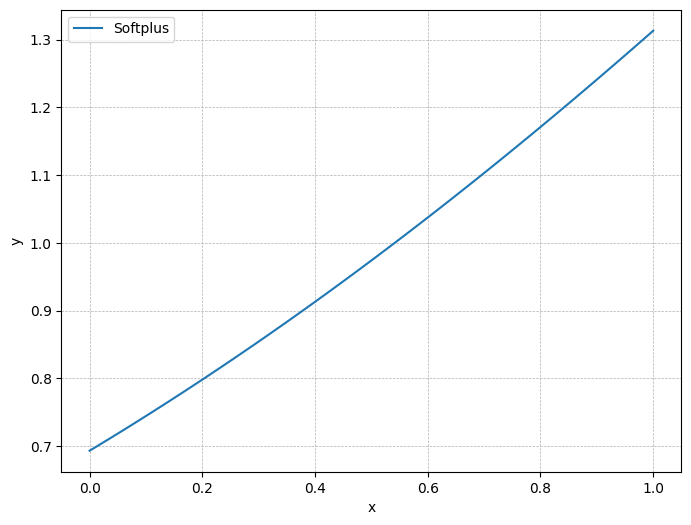

In [18]:
plot_functions((softplus,),("Softplus",))

Vamos a analizar la parte de arriba de la red

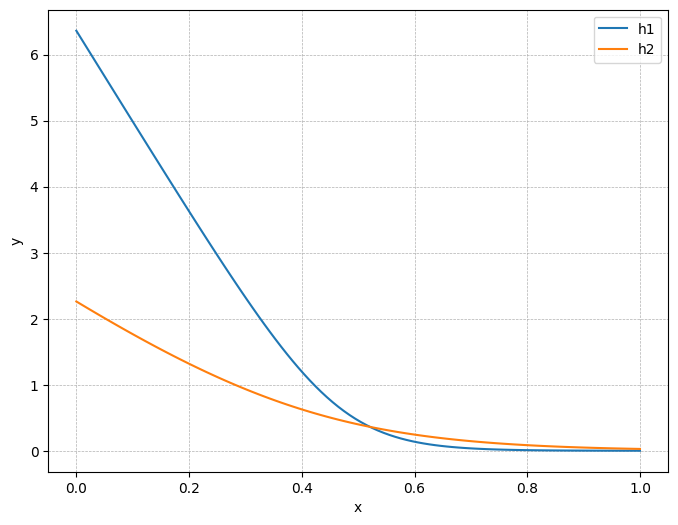

In [17]:
def h1(x):
  return softplus(model.l1.weight.detach()[0][0]*x + model.l1.bias.detach()[0])

def h2(x):
  return softplus(model.l1.weight.detach()[1][0]*x + model.l1.bias.detach()[1])

plot_functions((h1,h2),("h1","h2"))

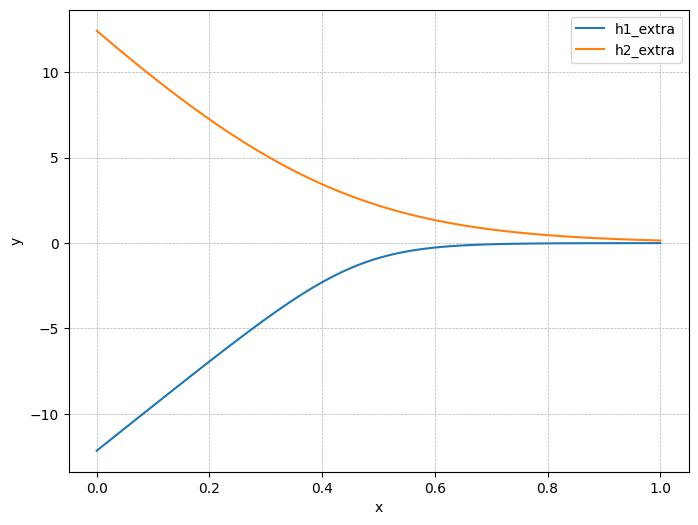

In [18]:
def h1_extra(x):
  return h1(x) * model.l2.weight.detach()[0][0]

def h2_extra(x):
  return h2(x) * model.l2.weight.detach()[0][1]

plot_functions((h1_extra,h2_extra),("h1_extra","h2_extra"))

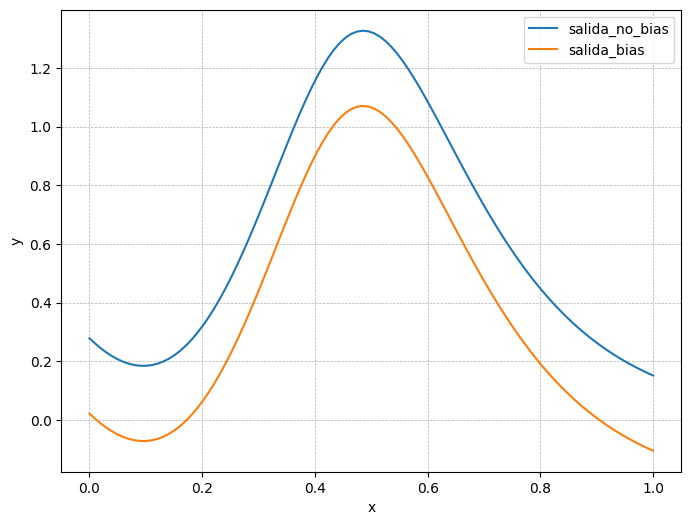

In [19]:
def salida_no_bias(x):
  return h1_extra(x)+h2_extra(x)


def salida_bias(x):
  return salida_no_bias(x)+model.l2.bias.detach()

plot_functions((salida_no_bias,salida_bias),("salida_no_bias","salida_bias"))